In [ ]:
#!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 1.3MB 6.0MB/s 
     |████████████████████████████████| 153kB 35.4MB/s 
     |████████████████████████████████| 2.9MB 41.3MB/s 
     |████████████████████████████████| 890kB 42.6MB/s 
     |████████████████████████████████| 1.1MB 41.8MB/s 
     |████████████████████████████████| 17.7MB 196kB/s 
     |████████████████████████████████| 245kB 45.0MB/s 
ERROR: transformers 3.5.1 has requirement tokenizers==0.9.3, but you'll have tokenizers 0.9.4 which is incompatible.


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)})

In [ ]:
emotion_dataset["train"]

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

'sadness'

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, max_length=128,padding="max_length", return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask":  tokenizer_output["attention_mask"],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [ ]:
batch_size = 64 # Задай batch_size
num_workers=4
train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,batch_size=batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = train_dataset.__getitem__(0)['input_ids'].to(device) # Получи токены из датасета
mask = train_dataset.__getitem__(0)['mask'].to(device) # Получи маску из датасета


model_0(input_ids=tokens,attention_mask=mask)[0] # Посмотри на аутпут

tensor([[ 0.2051, -0.9177,  0.7148, -0.1673, -0.2942, -0.9397]],
       device='cuda:0', grad_fn=<IndexBackward>)

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        src_ids=batch.get('input_ids').squeeze(1).to(device)
        src_mask=batch.get("mask").squeeze(1).to(device)
        trg=batch.get('target').unsqueeze(0).to(device)
        optimizer.zero_grad()
        output=model_0(input_ids=src_ids,attention_mask=src_mask,labels=trg)[1]
        loss=criterion(output,trg.squeeze(0))
        loss.backward()
        optimizer.step()
        train_loss+=loss
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            src_ids=batch['input_ids'].squeeze(1).to(device)
            src_mask=batch["mask"].squeeze(1).to(device)
            trg=batch['target'].unsqueeze(0).to(device)
            output=model_0(input_ids=src_ids,attention_mask=src_mask,labels=trg)[1]
            loss=criterion(output,trg.squeeze(0))
            valid_loss+=loss
            valid_acc+=accuracy_score(trg.permute(1,0).cpu().data.numpy(),output.cpu().argmax(1).data.numpy())
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        src_ids=batch['input_ids'].squeeze(1).to(device)
        src_mask=batch["mask"].squeeze(1).to(device)
        trg=batch['target'].unsqueeze(0).to(device)
        output=model_0(input_ids=src_ids,attention_mask=src_mask,labels=trg)[1]
        test_acc+=accuracy_score(trg.permute(1,0).cpu().data.numpy(),output.cpu().argmax(1).data.numpy())
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.5590261220932007,Valid Loss: 1.4483524560928345,Valid Acc: 0.44189453125



Train Loss: 1.3187575340270996,Valid Loss: 1.0795776844024658,Valid Acc: 0.60107421875



Train Loss: 0.9458984136581421,Valid Loss: 0.8288397192955017,Valid Acc: 0.70458984375



Train Loss: 0.6782820820808411,Valid Loss: 0.6971431970596313,Valid Acc: 0.755859375



Train Loss: 0.49699991941452026,Valid Loss: 0.6512503027915955,Valid Acc: 0.77587890625



Train Loss: 0.3834906220436096,Valid Loss: 0.6198797225952148,Valid Acc: 0.794921875



Train Loss: 0.3002370297908783,Valid Loss: 0.5506051778793335,Valid Acc: 0.8291015625



Train Loss: 0.2310665398836136,Valid Loss: 0.5436524748802185,Valid Acc: 0.8330078125



Train Loss: 0.18855899572372437,Valid Loss: 0.5442562699317932,Valid Acc: 0.83837890625



Train Loss: 0.16066063940525055,Valid Loss: 0.5088961124420166,Valid Acc: 0.85400390625
Test Acc: 0.8447265625


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
labels=['anger','fear','joy','love','sadness','surprize']
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    pred=labels[model(inp)[0].argmax(1)]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn), seq, pred

In [ ]:
def show_attention(seq, attentions,displayFirst):
    # Set up figure with colorbar
    
    if(displayFirst):
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111)
        cax = ax.matshow(attentions[0])
        fig.colorbar(cax)

        # Set up axes
        ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
        ax.set_yticklabels(['']+seq, fontsize=16)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()
    else:
        for i in attentions:
            fig = plt.figure(figsize=(20,20))
            ax = fig.add_subplot(111)
            cax = ax.matshow(i)
            fig.colorbar(cax)

            # Set up axes
            ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
            ax.set_yticklabels(['']+seq, fontsize=16)

            # Show label at every tick
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

            plt.show()
    

In [ ]:
text = emotion_dataset["test"]["text"][15] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

i was feeling as heartbroken as im sure katniss was
sadness


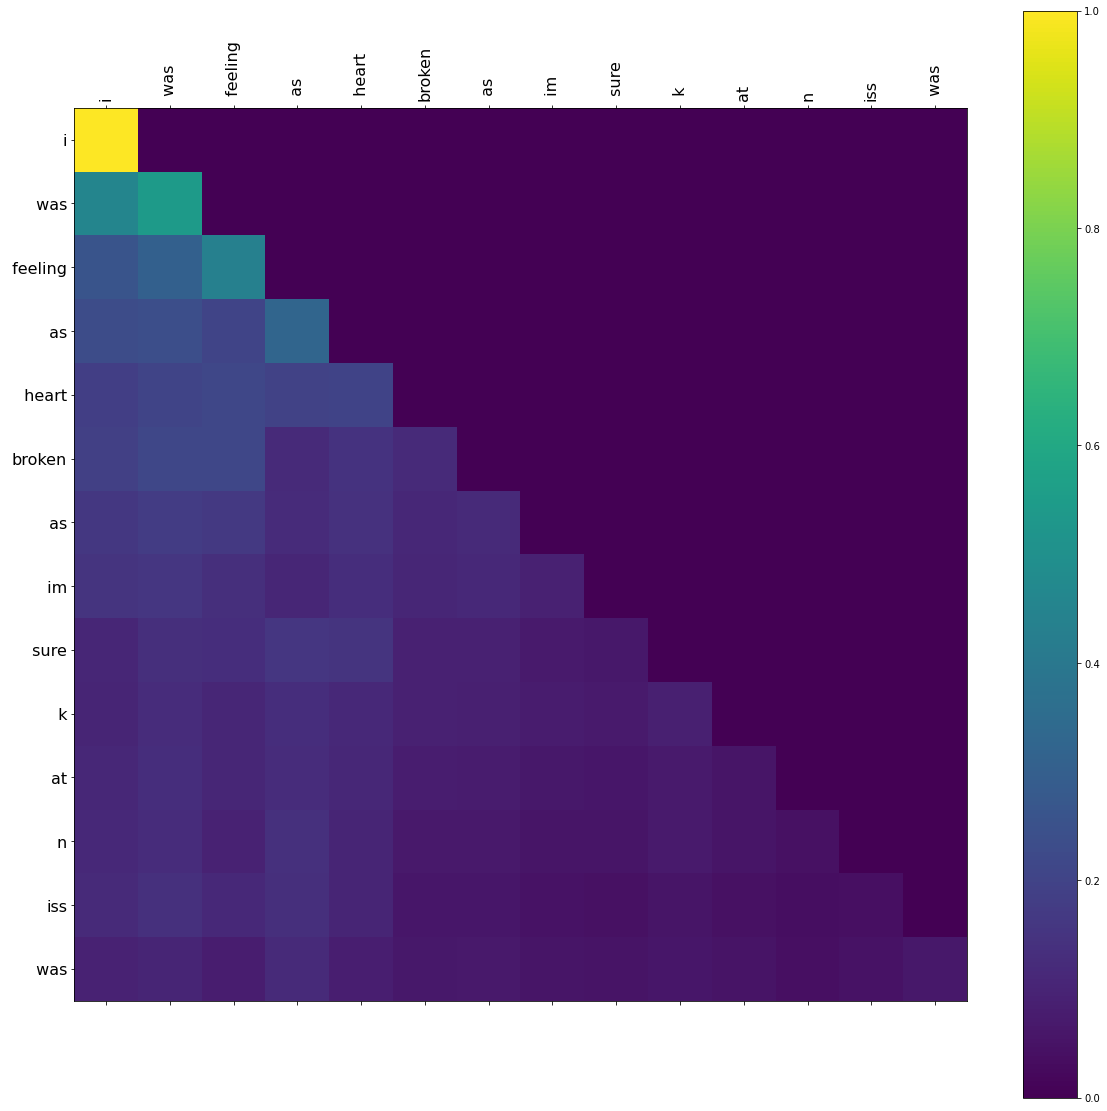

In [ ]:
attn,seq,pred = get_attention_matrixes(model_0, tokenizer, text)
print(text)
print(pred)
show_attention(seq, attn[-1],True)# You can check more attentions by choosing False

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        src_ids=batch.get('input_ids').squeeze(1).to(device)
        src_mask=batch.get("mask").squeeze(1).to(device)
        trg=batch.get('target').unsqueeze(0).to(device)
        optimizer.zero_grad()
        output=model_1(input_ids=src_ids,attention_mask=src_mask,labels=trg)[1]
        loss=criterion(output,trg.squeeze(0))
        loss.backward()
        optimizer.step()
        train_loss+=loss
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            src_ids=batch['input_ids'].squeeze(1).to(device)
            src_mask=batch["mask"].squeeze(1).to(device)
            trg=batch['target'].unsqueeze(0).to(device)
            output=model_1(input_ids=src_ids,attention_mask=src_mask,labels=trg)[1]
            loss=criterion(output,trg.squeeze(0))
            valid_loss+=loss
            valid_acc+=accuracy_score(trg.permute(1,0).cpu().data.numpy(),output.cpu().argmax(1).data.numpy())
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        src_ids=batch['input_ids'].squeeze(1).to(device)
        src_mask=batch["mask"].squeeze(1).to(device)
        trg=batch['target'].unsqueeze(0).to(device)
        output=model_1(input_ids=src_ids,attention_mask=src_mask,labels=trg)[1]
        test_acc+=accuracy_score(trg.permute(1,0).cpu().data.numpy(),output.cpu().argmax(1).data.numpy())
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.4485524892807007,Valid Loss: 0.87303626537323,Valid Acc: 0.69140625



Train Loss: 0.5941053628921509,Valid Loss: 0.33841603994369507,Valid Acc: 0.884765625



Train Loss: 0.34181445837020874,Valid Loss: 0.2446916550397873,Valid Acc: 0.908203125



Train Loss: 0.2401953935623169,Valid Loss: 0.20776352286338806,Valid Acc: 0.92138671875



Train Loss: 0.1999756395816803,Valid Loss: 0.19743983447551727,Valid Acc: 0.91796875
Test Acc: 0.923828125


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["test"]["text"][15] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

i was feeling as heartbroken as im sure katniss was
sadness


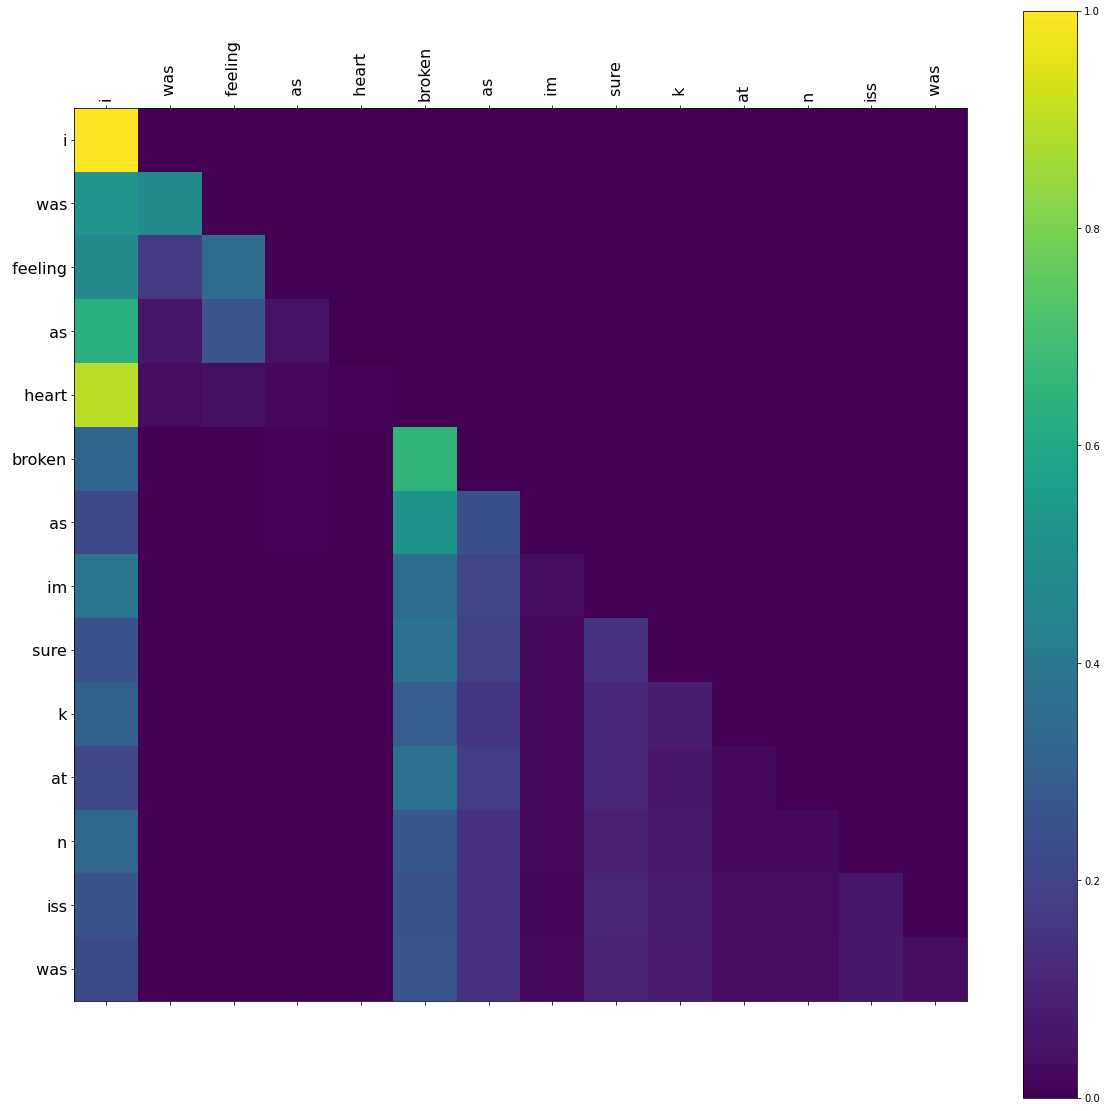

In [ ]:
attn,seq,pred = get_attention_matrixes(model_1, tokenizer, text)
print(text)
print(pred)
show_attention(seq, attn[-1],True)# You can check more attentions by choosing False

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

1) Лучше оказался второй подход, поскольку быстрее приближался к лучшему качеству и способен добится лучших его значений.

2) Больше всего она обращает внимания на имена, местоимения и прилагательные, особенно если они связаны с первым словом в предложении.

3) Не совсем понятна суть вопроса, однако при просмотре всех голов последнего слоя в обеих моделях явно заметно, что модель уделяет большее внимание первому слову и связанным с ним.

